## HW 8 - Part II

In [1]:
import warnings
warnings.filterwarnings("ignore")
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import statsmodels.tsa.api as tsa
from statsmodels.tsa.api import VAR
from statsmodels.tsa.vector_ar.util import comp_matrix

In [2]:
# Downloading the data
data = pd.read_csv('.\sign_svar_data.txt', header=None, delimiter=' ')
nobs=len(data)

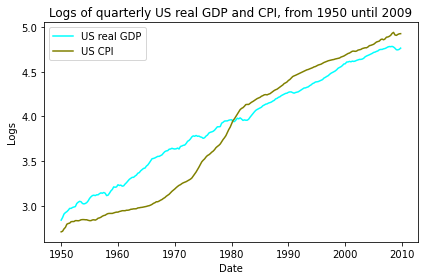

In [3]:
# The series are the logs of quarterly US real GDP and CPI, from 1950 until 2009.
# Create a pandas dataframe with proper datetime index and column labels

data.index=pd.date_range(start='1950Q1', freq='QS', periods=nobs)
data.rename(columns={0: "US real GDP", 1: "US CPI"})

# make a plot

plt.title("Logs of quarterly US real GDP and CPI, from 1950 until 2009")
plt.plot(data.index, data[0], label='US real GDP', color='cyan')
plt.plot(data.index, data[1], label='US CPI', color='olive')
plt.ylabel('Logs')
plt.xlabel('Date')
plt.legend()

plt.tight_layout()

In [4]:
# Transform the data into annualized growth rates (first difference multiplied by 400)
# create a new dataframe with the growth rates, and label the columns accordingly

data_growth=data.diff()*400
data_growth =data_growth.iloc[1:,:]

In [5]:
# Create a VAR model for the growth rates

var_model_growth = tsa.VAR(data_growth)

In [6]:
# estimate the model with p=2 including a constant and a time trend 

var_model_growth_p2 = var_model_growth.fit(2, trend='ct')
var_model_growth_p2.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 16, May, 2022
Time:                     16:50:36
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    4.55342
Nobs:                     237.000    HQIC:                   4.44860
Log likelihood:          -1179.35    FPE:                    79.6662
AIC:                      4.37782    Det(Omega_mle):         75.7806
--------------------------------------------------------------------
Results for equation 0
           coefficient       std. error           t-stat            prob
------------------------------------------------------------------------
const         3.291427         0.650896            5.057           0.000
trend        -0.004115         0.003424           -1.202           0.229
L1.0          0.264159         0.064503            4.095           0.000
L1.1         -0.080357 

In [7]:
# Compute and print the covariance matrix of the residuals, call it Sigma
Sigma = var_model_growth_p2.resid_acov(2)[0]
print(Sigma)

[[12.17167405 -0.30910097]
 [-0.30910097  5.92258163]]


In [8]:
# Compute the companion matrix of the estimated VAR
companion = comp_matrix(var_model_growth_p2.coefs)

In [9]:
# Compute and store in variable MA_VAR1 the first 10 coefficients of 
# the MA representation of the VAR(1) representaton of the estimated VAR

# Note: use a loop. The function np.linalg.matrix_power may be helpful. The dimensions of MA_VAR1 must be (10, 4, 4)

MA_VAR1=np.zeros((10,4,4))
C = np.zeros_like(companion)
for j in range(10):
    C=np.linalg.matrix_power(companion, j)
    MA_VAR1[j,:,:]=C 

In [11]:
# from MA_VAR1 compute the coefficients of the MA representation of the estimated VAR. Store in MA_VAR2

# Note: use a selection matrix. The dimensions of MA_VAR2 must be (10, 2, 2)
MA_VAR2=(np.identity(4)@MA_VAR1)[:,:2,:2]

</div> <div class="alert alert-block alert-danger">

no need to multiply by the identity. My suggestion was to use a selection matrix 

```
S = np.zeros((2, 4 ))
S[:2,:2] = np.eye(2)
```
    
but 

```
MA_VAR2 = MA_VAR1[:,:2,:2]
```

is even better.

In [36]:
# confirm that MA_VAR2 is identical to the output from results.ma_rep(maxn=10) (results is the estimated VAR)

# Note: you can use numpy's testing.assert_allclose

np.testing.assert_allclose(MA_VAR2, var_model_growth_p2.ma_rep(maxn=9))

Suppose that we want to identify aggregate supply and demand shocks.
We could impose the following sign restrictions:
* a supply shock has a positive effect on output and a negative effect on prices
* a demand shock has a positive effect on both output and prices.

Note that these are restrictions on the effect of the shocks on the __levels__ of our variable. We can transform impulse responses of growth rates into impulse  responses of levels by computing the cumulative sums. 

To impose the sign restrictions we need to find an orthogonal matrix $Q$ such that the matrix 

$$B_0^{-1} = PQ$$ 

results in reponses with the right signs, where $P$ is any matrix such that $$P P^{\prime} = \Sigma$$

We can use the Cholesky factor of $\Sigma$ as our $P$.

In [13]:
# One trivial candidate for Q is the identity matrix.
# Check if it results in impulse responses satisfying our sign restrictions.

P = np.linalg.cholesky(Sigma)
F = np.zeros((10,2,2))

for i in range(10):
    F[i,:,:] = MA_VAR2[i,:,:]@P

In [14]:
P

array([[ 3.48879263,  0.        ],
       [-0.08859826,  2.4320222 ]])

</div> <div class="alert alert-block alert-danger">

The VAR estimation result has a method for computing orthogonalized MA coefficient matrices 

```
irf_nosign = var_model_growth_p2.orth_ma_rep(maxn=9, P=P)

```

You can confirm the cumulative IRFs are the same with

```
cumirf_nosign = irf_nosign.cumsum(axis=0)
np.testing.assert_array_almost_equal(cumirf_nosign, F.cumsum(axis=0))
```
    
You can also use another method that will compute and plot the cumulative IRFs
   
```    
irf = var_model_growth_p2.irf(10)
irf.plot_cum_effects(orth=True, figsize=(12,3));
```    

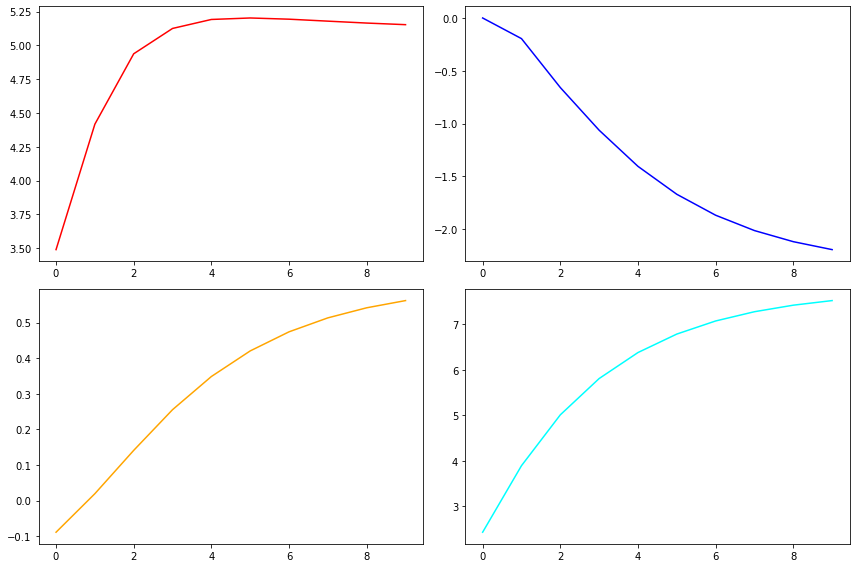

In [15]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(12,8))
tick = np.arange(10)

axes = ax.flatten()
axes[0].plot(tick, F[:,0,0].cumsum(), color='red') 
axes[1].plot(tick, F[:,0,1].cumsum(), color='b')
axes[2].plot(tick, F[:,1,0].cumsum(), color='orange')
axes[3].plot(tick, F[:,1,1].cumsum(), color='cyan')

plt.tight_layout()

</div> <div class="alert alert-block alert-danger">

Are these IRFs consistent with our sign restrictions?

Define $Q(\theta)$ as

$$ Q(\theta) =  \left[\begin{array}{cc}
\cos(\theta) & \sin(\theta)\\
-\sin(\theta) & \cos(\theta) \\
\end{array}\right]$$

for $\theta \in (0, 2 \pi)$

In [30]:
# Compute Q for theta = 0.2*np.pi. Confirm that it is an orthogonal matrix. Confirm that (P@Q)@(P@Q).T = Sigma
def Q(theta):
    Q = [[np.cos(theta), np.sin(theta)],
             [-np.sin(theta), np.cos(theta)]];
    return Q

</div> <div class="alert alert-block alert-danger">

The type of your Q is a `list` (check `type(Q(0.2*np.pi))`). You should always use np.array to do math!

In [32]:
np.testing.assert_array_almost_equal((P@Q(0.2*np.pi))@(P@Q(0.2*np.pi)).T, Sigma)

In [33]:
# Check if this choice of Q results in impulse responses satisfying our sign restrictions.
# Again, make sure you understand the order of variables and shocks in the impulse responses you computed. 

#Tip: You should see responses consistent with our sign restrictions. This can be used to fix the order - which shock is supply and which demand.

B = P @ Q(0.2*np.pi)
B

array([[ 2.82249253,  2.05066086],
       [-1.50118428,  1.91547054]])

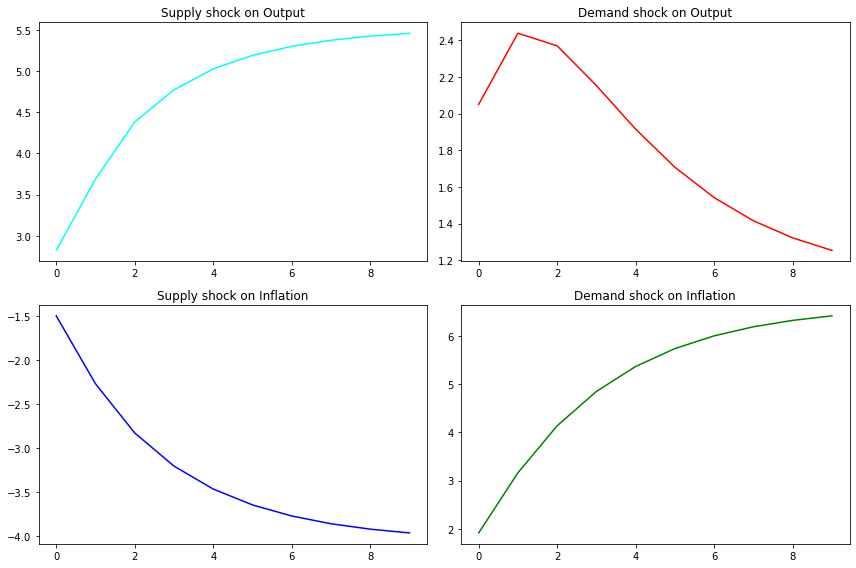

In [18]:
F = np.zeros((10,2,2))

for i in range(10):
    F[i,:,:] = MA_VAR2[i,:,:]@B


# Plot 
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(12,8))
nps = np.arange(10)

ax = ax.flatten()
ax[0].plot(nps, F[:,0,0].cumsum(), color='cyan')   # Supply shock on Output
ax[0].set_title("Supply shock on Output")
ax[1].plot(nps, F[:,0,1].cumsum(), color='red')   # Demand shock on Output
ax[1].set_title("Demand shock on Output")
ax[2].plot(nps, F[:,1,0].cumsum(), color='blue')   # Supply shock on Inflation
ax[2].set_title("Supply shock on Inflation")
ax[3].plot(nps, F[:,1,1].cumsum(), color='green')   # Demand shock on Inflation
ax[3].set_title("Demand shock on Inflation")

plt.tight_layout()

</div> <div class="alert alert-block alert-danger">

Are these IRFs consistent with our sign restrictions?

Given a 10x2x2 array of impulse responses, we want to be able to check if our sign restroctions are satisfied. That is, see if all responses of output to a supply and demand shocks are positive,  all responses of prices to a supply shock are negative, and all responses of prices to a demand shock are positive.

Some ideas for useful ways to index numpy arrays can be explored [here](https://jakevdp.github.io/PythonDataScienceHandbook/02.07-fancy-indexing.html)

In [19]:
#Generate 1000 sets of impulse responses that satisfy the sign restrictions as follows

#- draw theta from the interval (0, 2*pi) 
#- compute Q(theta) 
#- compute the impulse responses and check if the sign restrictions are satisfied. If yes keep them, otherwise dont.
#- continue until you have 1000 valid sets of impulse responses

FF = np.zeros((10,2,2,1))

while True:
    theta = np.random.uniform(0, 2*np.pi);
    B = P @ Q(theta)
    F = np.zeros((10,2,2))
    for i in range(10):
        F[i,:,:] = MA_VAR2[i,:,:]@B
    if all(i>0 for i in F[:,0,0].cumsum()) and all(i>0 for i in F[:,0,1].cumsum()) and all(i<0 for i in F[:,1,0].cumsum()) and all(i>0 for i in F[:,1,1].cumsum()):
        FF = np.concatenate((FF, F[...,np.newaxis]),axis=3)
        
    if FF.shape[3]==1001:
        break

FF = FF[:,:,:,1:]

</div> <div class="alert alert-block alert-danger">

This code
```
    F = np.zeros((10,2,2))
    for i in range(10):
        F[i,:,:] = MA_VAR2[i,:,:]@B
```        

can be replaced with 
```
impulse = var_model_growth_p2.orth_ma_rep(maxn=9, P=B)
```
    
and even better, compute the cumulative IRFs with
```    
impulse = var_model_growth_p2.orth_ma_rep(maxn=9, P=B).cumsum(axis=0)    
```    
and if you define (outside the loop) the indices of the rows and columns that should be positive/negative with
    
```
row_pos = np.array([0,0,1])
col_pos = np.array([0,1,1])

row_neg = np.array([1])
col_neg = np.array([0])
```
    
you can check if the sign restrictions are satisfied with
    
```
np.all([np.all(impulse[:, row_pos, col_pos]>=0), np.all(impulse[:, row_neg, col_neg]<0)])
```
    
    
For storage of the selected IRFs, it may be simpler to use something like
    
```    
impulse_select = []


while len(impulse_select)<1000:
    ...

    if np.all([np.all(impulse[:, row_pos, col_pos]>=0), np.all(impulse[:, row_neg, col_neg]<0)]):
        impulse_select.append(impulse)    
```

Then each element of the list will be of same shape as in the previous plot

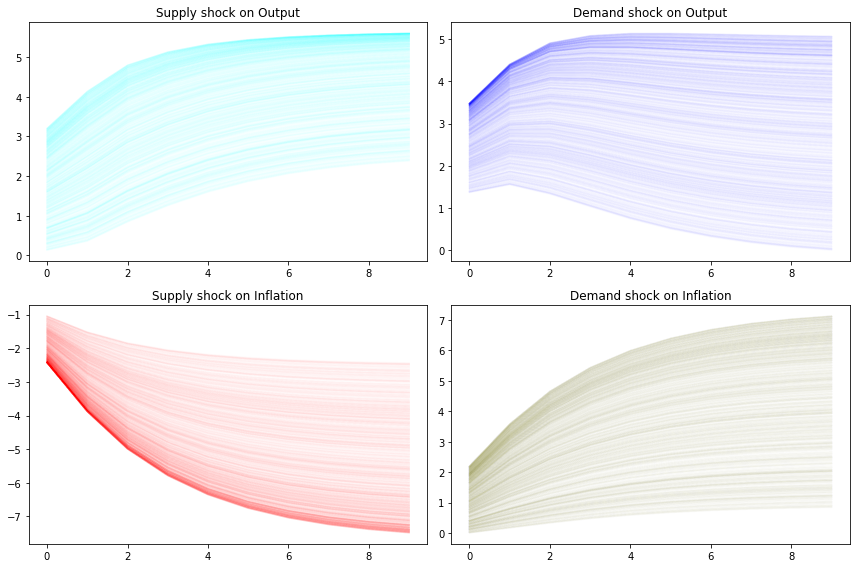

In [20]:
# Make a 2x2 plot of all impulse responses for each variable and shock. 
# Label each subplot (which variable and shock)
# use the same color for each line, and some small value for transparency (e.g. alpha=0.01) 

# Plot 
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(12,8))
nps = np.arange(10)
ax = ax.flatten()

for i in range(1000):      
    ax[0].plot(nps, FF[:,0,0,i].cumsum(), color='cyan', alpha=0.01)   
    ax[0].set_title("Supply shock on Output")
    ax[1].plot(nps, FF[:,0,1,i].cumsum(), color='b', alpha=0.01)   
    ax[1].set_title("Demand shock on Output")
    ax[2].plot(nps, FF[:,1,0,i].cumsum(), color='red', alpha=0.01)  
    ax[2].set_title("Supply shock on Inflation")
    ax[3].plot(nps, FF[:,1,1,i].cumsum(), color='olive', alpha=0.01)  
    ax[3].set_title("Demand shock on Inflation")

plt.tight_layout()

Another method for generating candidates for Q is based on the QR decomposition.
One common approach is to apply it to a random matrix $H$ with that $H_{ij} \sim N(0, 1)$, which guarantees that $H$ is invertable with probability 1. The QR factorization of $H$ will be unique if the diagonal elements of $R$ are positive. This can be enforced by reversing the signs of the elements of the i-th column of $Q$ if the i-th diagonal element of $R$ is negative. Here is one way to generate such $Q$ in python

```
    [Q,R] = np.linalg.qr(np.random.randn(n,n))

    for j in range(n):
        if R[j,j]<0:
            Q[:,j] = -Q[:,j]
```

In [21]:
# Generate another 1000 sets of impulse responses that satisfy the sign restrictions using the QR approach.

FF_QR = np.zeros((10,2,2,1))
n = 2

while True:
    [QQ,R] = np.linalg.qr(np.random.randn(n,n))
    for j in range(n):
        if R[j,j]<0:
            QQ[:,j] = -QQ[:,j]
    B = P @ QQ
    F = np.zeros((10,2,2))
    for i in range(10):
        F[i,:,:] = MA_VAR2[i,:,:]@B
    if all(i>0 for i in F[:,0,0].cumsum()) and all(i>0 for i in F[:,0,1].cumsum()) and all(i<0 for i in F[:,1,0].cumsum()) and all(i>0 for i in F[:,1,1].cumsum()):
        FF_QR = np.concatenate((FF_QR, F[...,np.newaxis]),axis=3)
        
    if FF_QR.shape[3]==1001:
        break

FF_QR = FF_QR[:,:,:,1:]


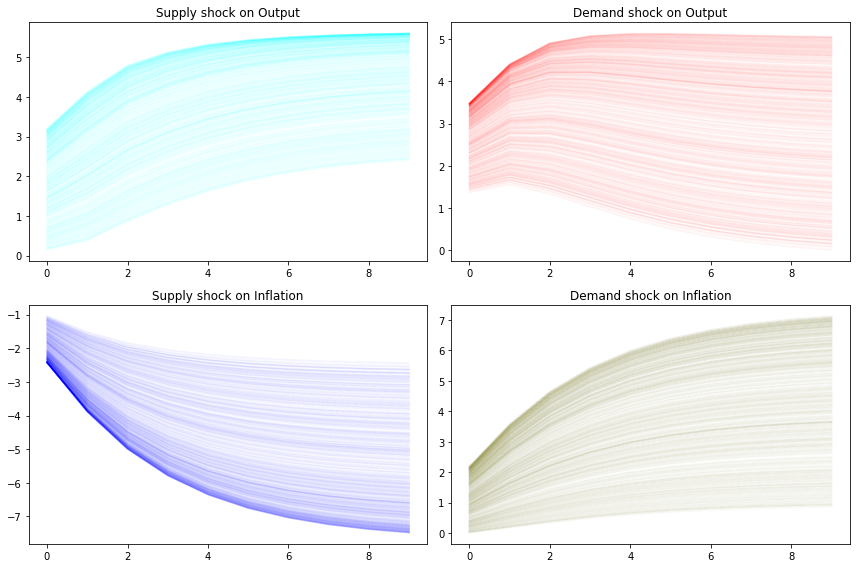

In [22]:
# Make another 2x2 plot of all impulse responses for each variable and shock.
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(12,8))
nps = np.arange(10)
ax = ax.flatten()

for i in range(1000):      
    ax[0].plot(nps, FF_QR[:,0,0,i].cumsum(), color='cyan', alpha=0.01)   
    ax[0].set_title("Supply shock on Output")
    ax[1].plot(nps, FF_QR[:,0,1,i].cumsum(), color='red', alpha=0.01)   
    ax[1].set_title("Demand shock on Output")
    ax[2].plot(nps, FF_QR[:,1,0,i].cumsum(), color='b', alpha=0.01)   
    ax[2].set_title("Supply shock on Inflation")
    ax[3].plot(nps, FF_QR[:,1,1,i].cumsum(), color='olive', alpha=0.01)   
    ax[3].set_title("Demand shock on Inflation")

plt.tight_layout()